<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_q1studentcharacteristics_withsessionseen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Approach: 
1. group by delta, history fraction for every student, see if you can see who are the top performers, bottom performers. Is there a way to cluster them?

after trying in prev notebook, we now add session seen, and replace history correct with history fraction correct. 

In [1]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


In [4]:
datadfq1 = decompress_pickle(path_name+"Unseen_words_training_set.pbz2") 

In [5]:
datadfq1.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,student_word,student_lang
7,1.0,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
15,1.0,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
20,1.0,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,"(u:dDwF, c84476c460737d9fb905dca3d35ec995)","(u:dDwF, en)"
21,1.0,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,"(u:dDwF, 1a913f2ded424985b9c02d0436008511)","(u:dDwF, en)"
22,1.0,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,"(u:dDwF, 38b770e66595fea718366523b4f7db3f)","(u:dDwF, en)"


For now, without looking at individual time traces of student-word, we will just look at student id, delta, history fraction, and see if we can predict if they forgot the word. (the difficulty of the word being captured in history fraction)

In [6]:
datadfq1['user_id'].value_counts().sort_values(ascending=False).head(3)

u:bcH_    12629
u:IY_      5528
u:hDLF     5147
Name: user_id, dtype: int64

We can use u:bcH_ as an example to train on. 

In [18]:
user1 = datadfq1.loc[datadfq1['user_id']=='u:bcH_']
user1['history_frac'] = user1['history_correct']/user1['history_seen']
user1 = user1[['delta','history_frac','p_recall','history_seen','session_seen']] # added session seen.
user1['p_forgot'] = 1 - user1['p_recall']
user1['p_forgot_bin'] = np.where(user1['p_forgot']>0,1,0).astype(int)
user1 = user1.drop(['p_forgot','p_recall'],axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
user1 = user1.sample(frac=1)

In [ ]:
from sklearn.model_selection import train_test_split

X = user1.drop('p_forgot_bin',axis=1)
y = user1['p_forgot_bin']

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

In [ ]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.622172
 0    0.377828
 Name: p_forgot_bin, dtype: float64, 1    0.622328
 0    0.377672
 Name: p_forgot_bin, dtype: float64)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

X_train = mm_scaler.fit_transform(X_train_unscaled)
X_test = mm_scaler.fit(X_test_unscaled)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_validate

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV

classweight_vals = [{0:0.1, 1:0.9}, {0:0.01, 1:0.99}, {0:0.001,1:0.999}]
max_depth_vals = [2,4,6,8,10,12]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['max_depth'] = max_depth_vals


dtree = DecisionTreeClassifier()
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=4,scoring = scoring_metrics, verbose=15,refit=False,return_train_score=True)

gridsearch_obj.fit(X_train_unscaled,y_train)


In [ ]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,"{0: 0.1, 1: 0.9}",2,0.02,0.02,0.62,0.71,0.63,0.77,1.00
1,"{0: 0.1, 1: 0.9}",4,0.02,0.02,0.62,0.74,0.65,0.77,1.00
2,"{0: 0.1, 1: 0.9}",6,0.03,0.03,0.62,0.74,0.65,0.76,0.99
3,"{0: 0.1, 1: 0.9}",8,0.04,0.03,0.62,0.75,0.65,0.76,0.98
4,"{0: 0.1, 1: 0.9}",10,0.07,0.04,0.62,0.74,0.65,0.76,0.97
5,"{0: 0.1, 1: 0.9}",12,0.04,0.02,0.61,0.73,0.63,0.75,0.94
6,"{0: 0.01, 1: 0.99}",2,0.01,0.02,0.62,0.70,0.61,0.77,1.00
7,"{0: 0.01, 1: 0.99}",4,0.02,0.02,0.62,0.72,0.63,0.77,1.00
8,"{0: 0.01, 1: 0.99}",6,0.03,0.02,0.62,0.74,0.65,0.76,0.99
9,"{0: 0.01, 1: 0.99}",8,0.03,0.02,0.62,0.75,0.65,0.76,0.99


class_weight = {0: 0.3, 1: 0.7}, max_depth=4 has the best results, although test accuracy was the same as always 1 baseline throughout. 

In [ ]:
gridcv['weight1'] = gridcv['param_class_weight'].apply(lambda x: x[1])

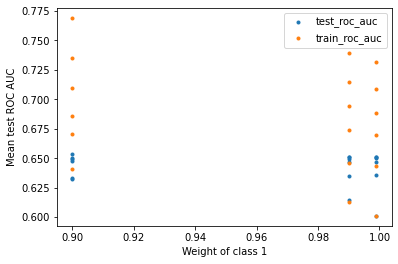

In [ ]:
plt.figure()
plt.xlabel("Weight of class 1")
plt.ylabel("Mean test ROC AUC")
plt.plot(gridcv['weight1'],gridcv['mean_test_roc_auc'],'.' ,label = 'test_roc_auc')
plt.plot(gridcv['weight1'],gridcv['mean_train_roc_auc'],'.', label = 'train_roc_auc')
plt.legend()
plt.show()

This justifies considering even higher weights for 1, since the mean test ROC AUC keeps increasing. we will keep depth to 4. 

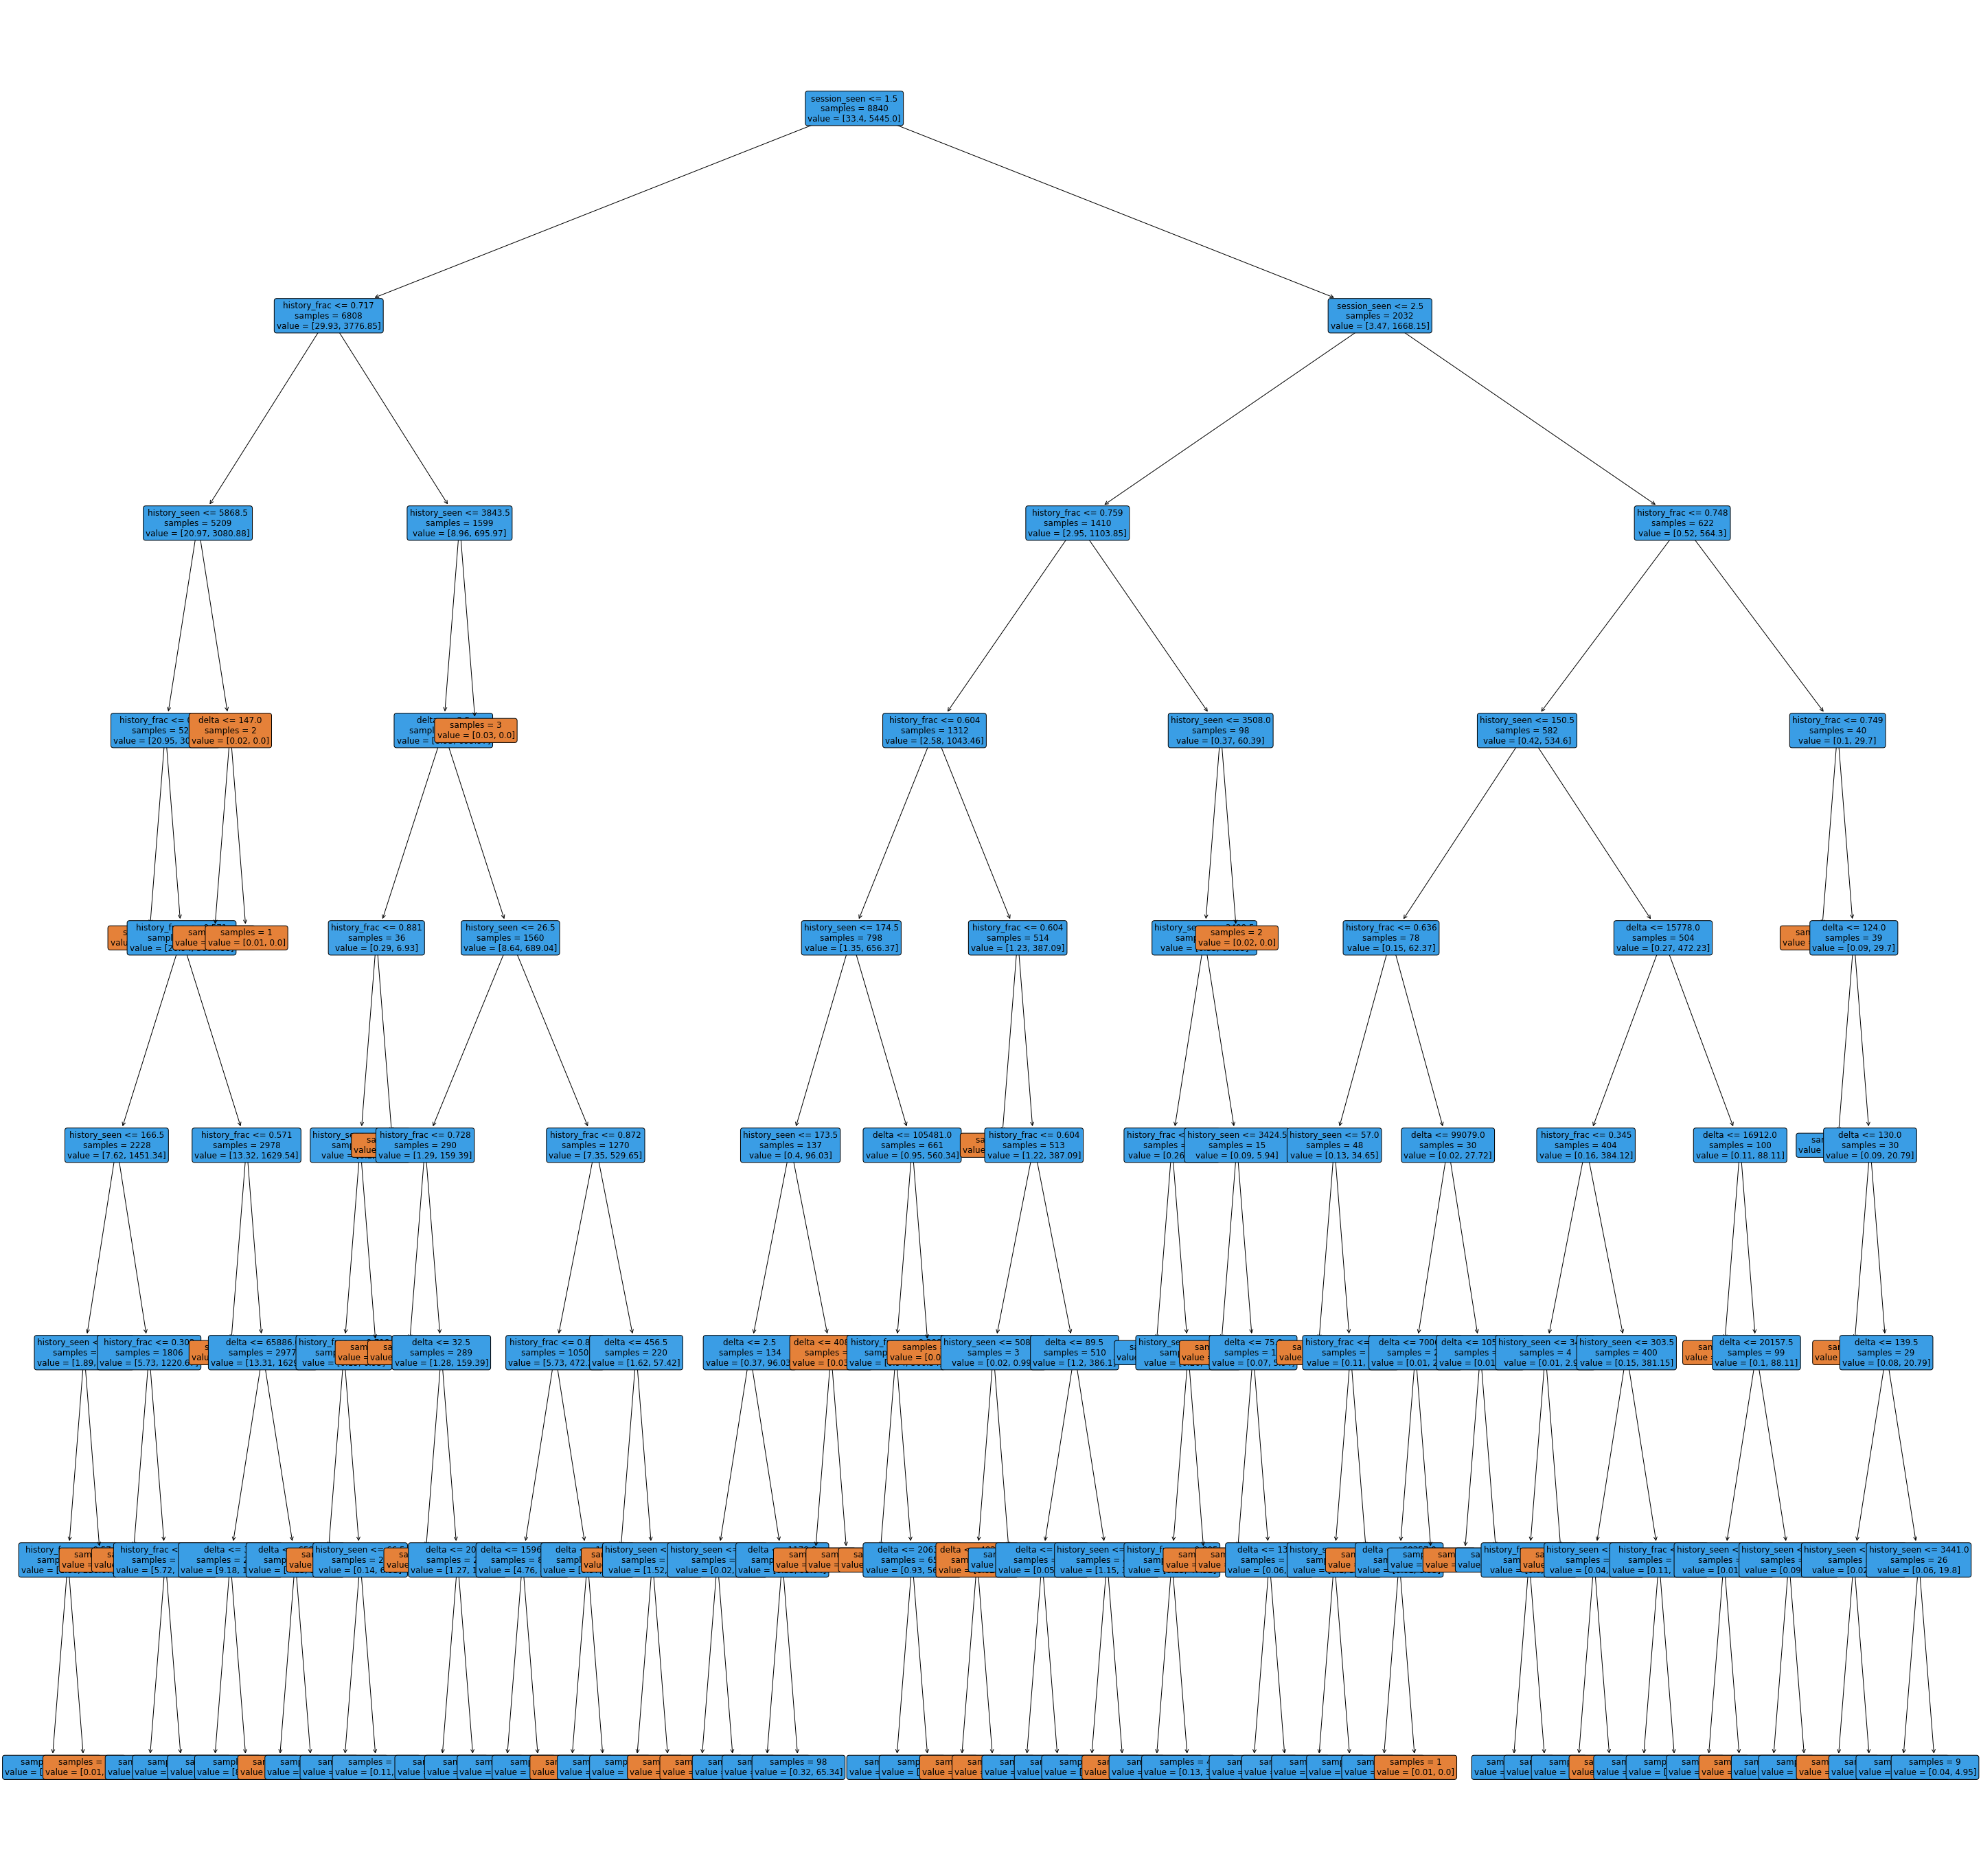

In [ ]:
dtreebest = DecisionTreeClassifier(max_depth=8,class_weight = {0:.01,1:0.99})
dtreebest.fit(X_train_unscaled,y_train)

from sklearn.tree import plot_tree
plt.figure(figsize=(50,50))
plot_tree(dtree, 
          feature_names=X.columns, 
          rounded=True,
          impurity=False,
          filled=True,
          fontsize=12)
plt.show()

In [ ]:
pd.Series(dict(zip(X_train_unscaled.columns,dtreebest.feature_importances_))).sort_values(ascending=False)

history_seen    0.431067
delta           0.268045
history_frac    0.255782
session_seen    0.045106
dtype: float64

Trying random forests:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

my_random_forest = RandomForestClassifier(n_estimators=3,max_features=1)
my_random_forest.fit(X_train_unscaled, y_train)
 

RandomForestClassifier(max_features=1, n_estimators=3)

In [ ]:
from sklearn.metrics import accuracy_score

y_train_predicted = my_random_forest.predict(X_train_unscaled)
y_test_predicted = my_random_forest.predict(X_test_unscaled)
accuracy_score(y_train,y_train_predicted), accuracy_score(y_test,y_test_predicted)

(0.9190045248868778, 0.5814198997096859)

Way overfit with a very small number of estimators inspite of adding max_features limit. (only 3 features anyway)

Just for fun, we can try XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_unscaled)
X_mm_train = mm_scaler.transform(X_train_unscaled)
X_mm_test = mm_scaler.transform(X_test_unscaled)
XGB_model = XGBClassifier()
XGB_model.fit(X_mm_train, y_train)
print(f"XG Boost test set score: {XGB_model.score(X_mm_test, y_test)}")
print(f"XG Boost train set score: {XGB_model.score(X_mm_train, y_train)}")

XG Boost test set score: 0.6421219319081551
XG Boost train set score: 0.6704751131221719


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
AB_model = AdaBoostClassifier()
AB_model.fit(X_mm_train, y_train)
print(f"Ada Boost test set score: {AB_model.score(X_mm_test, y_test)}")
print(f"Ada Boost train set score: {AB_model.score(X_mm_train, y_train)}")

Ada Boost test set score: 0.6355238849300607
Ada Boost train set score: 0.6596153846153846


With session seen and history fraction added in, performance is slightly improved, but not by much. Test accuracy is still at baseline all 1 level.

We will add languade fummies, surface form length and modifier tags to the model. If ther is any improvement, we can then look at other students with the same features and without. Then we can test those.

In [11]:
q1lexemes = decompress_pickle(path_name+"q1_lexeme_features.pbz2")

In [12]:
q1lexemes.head()

,index,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,...,êt,ête,ía,ían,ías,ín,ît,ña,ño,ón
0,7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[],4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]",5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.512787,0.0
2,21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]",3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]",5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[],1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [39]:
datadfq1['user_id'].value_counts().sort_values(ascending=False).head(3)


u:bcH_    12629
u:IY_      5528
u:hDLF     5147
Name: user_id, dtype: int64

In [35]:
user1 = datadfq1.loc[datadfq1['user_id']=='u:bcH_']
user1['history_frac'] = user1['history_correct']/user1['history_seen']
user1 = user1[['delta','history_frac','p_recall','history_seen','session_seen','lexeme_id','timestamp']] # added session seen.
user1['p_forgot'] = 1 - user1['p_recall']
user1['p_forgot_bin'] = np.where(user1['p_forgot']>0,1,0).astype(int)
user1 = user1.drop(['p_forgot'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
user1.head()

,delta,history_frac,p_recall,history_seen,session_seen,lexeme_id,timestamp,p_forgot_bin
193803,61015,0.738854,0.0,157,1,55f383178cf0fdc463ef1ebf91bd288d,1362092353,1
193805,83951,0.607735,0.0,181,1,9eedd98a29691237d18c127468452836,1362092353,1
193806,61191,0.638554,0.0,913,1,4adf5cd40d521b02a9cc241bf3adc6bb,1362092353,1
193807,83951,0.623656,0.0,93,1,b830ca5fa936b0cff94fe712d6847f29,1362092353,1
193809,150495,0.648276,1.0,145,1,715176b2531f23894fa17069ca039496,1362092353,0


Getting surface form length, langugae dummies from q1lexemes:

In [37]:
q1lexemes_sub = q1lexemes[['lexeme_id','learning_language','sf_length']]

Joining with user1

In [70]:
user1_1 = pd.merge(left = user1, right = q1lexemes_sub,left_on = 'lexeme_id',right_on = 'lexeme_id',how='left')

In [71]:
user1_1[user1_1['sf_length']>6]

,delta,history_frac,p_recall,history_seen,session_seen,lexeme_id,timestamp,p_forgot_bin,learning_language,sf_length
24,61787,0.500000,0.333333,156,3,3817a177b72ad3d57dab30f6e1475f72,1362092494,1,en,8
25,61649,0.484932,1.000000,365,1,563cc940cf4f3edeecc73ee5e6ab45d1,1362092494,0,en,7
65,61787,0.619883,0.000000,171,2,03b4dc0d4f3687f700b89fd636758868,1362092494,1,en,7
77,1795763,0.931034,1.000000,29,1,e3c71404c219ae1ca7c1768b7a3cfc95,1362092593,0,en,10
90,83749,0.573407,1.000000,361,1,ef1f94c0e977e97bd02772867e9110f1,1362092593,0,en,7
...,...,...,...,...,...,...,...,...,...,...
12591,144,0.454936,1.000000,466,1,563cc940cf4f3edeecc73ee5e6ab45d1,1363066201,0,en,7
12594,1016,0.472906,0.500000,203,4,3817a177b72ad3d57dab30f6e1475f72,1363066201,1,en,8
12597,105564,0.558442,1.000000,154,1,601be72748838f924f865120aa89fc28,1363066201,0,en,9
12622,3579,0.552901,0.500000,293,2,89f8faba0f8e91b059439456dffaa20d,1363066201,1,en,9


In [60]:

timetrace = user1_1.loc[user1_1['lexeme_id']=='55f383178cf0fdc463ef1ebf91bd288d',['delta','timestamp','history_frac','p_forgot_bin','p_recall']].sort_values(by='timestamp',ascending=True)
timetrace['deltacum'] = timetrace['delta'].shift(-1).cumsum()
timetrace

,delta,timestamp,history_frac,p_forgot_bin,p_recall,deltacum
0,61015,1362092353,0.738854,1,0.0,1347.0
358,1347,1362093700,0.734177,1,0.0,2342.0
650,995,1362094695,0.729560,0,1.0,2439.0
699,97,1362094791,0.731250,0,1.0,107519.0
1016,105080,1362199870,0.732919,0,1.0,192126.0
2403,84607,1362284476,0.734568,1,0.0,281271.0
2728,89145,1362373620,0.730061,1,0.0,283352.0
3385,2081,1362375700,0.725610,0,1.0,453816.0
5464,170464,1362546163,0.727273,1,0.0,539934.0
6018,86118,1362632281,0.722892,0,1.0,866302.0


,delta,timestamp,history_frac,p_forgot_bin,p_recall,deltacum
0,61015,1362092353,0.738854,1,0.0,61015
358,1347,1362093700,0.734177,1,0.0,62362
650,995,1362094695,0.729560,0,1.0,63357
699,97,1362094791,0.731250,0,1.0,63454
1016,105080,1362199870,0.732919,0,1.0,168534
2403,84607,1362284476,0.734568,1,0.0,253141
2728,89145,1362373620,0.730061,1,0.0,342286
3385,2081,1362375700,0.725610,0,1.0,344367
5464,170464,1362546163,0.727273,1,0.0,514831
6018,86118,1362632281,0.722892,0,1.0,600949


In [59]:
timetrace2 = user1_1.loc[user1_1['lexeme_id']=='601be72748838f924f865120aa89fc28',['delta','timestamp','history_frac','p_forgot_bin','p_recall']].sort_values(by='timestamp',ascending=True)
timetrace2['deltacum'] = timetrace2['delta'].shift(-1).cumsum()

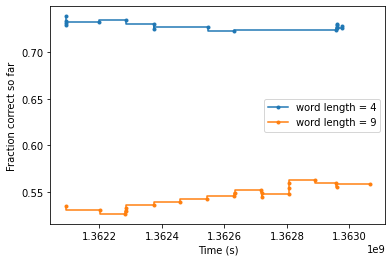

In [63]:
plt.figure()
plt.step(timetrace['timestamp'],timetrace['history_frac'],'.-',label="word length = 4")
plt.step(timetrace2['timestamp'],timetrace2['history_frac'],'.-',label="word length = 9")
plt.xlabel("Time (s)")
plt.ylabel("Fraction correct so far")
plt.legend()
plt.show()

In [72]:
user1_1 = user1_1.drop(['p_recall','lexeme_id','timestamp','learning_language'],axis=1)

In [76]:
from sklearn.model_selection import train_test_split
X = user1_1.drop('p_forgot_bin',axis=1)
y = user1_1['p_forgot_bin']
X_train_unscaled,X_test_unscaled,y_train,y_test = train_test_split(X,y,test_size=0.1,stratify= y)

In [77]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

X_train = mm_scaler.fit_transform(X_train_unscaled)
X_test = mm_scaler.fit(X_test_unscaled)

In [86]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_validate

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV

classweight_vals = [{0:0.5,1:0.5},{0:.45,1:.55},{0:0.1,1:0.9},{0:0.4,1:0.6},{0:0.3,1:0.7},{0:0.2,1:0.8}]
max_depth_vals = [2,4,6,8,10,12]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['max_depth'] = max_depth_vals


dtree = DecisionTreeClassifier()
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=4,scoring = scoring_metrics, verbose=15,refit=False,return_train_score=True)

gridsearch_obj.fit(X_train_unscaled,y_train)


Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV 1/4; 1/36] START class_weight={0: 0.5, 1: 0.5}, max_depth=2.................
[CV 1/4; 1/36] END class_weight={0: 0.5, 1: 0.5}, max_depth=2; accuracy: (train=0.642, test=0.639) average_precision: (train=0.723, test=0.716) f1: (train=0.740, test=0.738) recall: (train=0.817, test=0.819) roc_auc: (train=0.646, test=0.636) total time=   0.0s
[CV 2/4; 1/36] START class_weight={0: 0.5, 1: 0.5}, max_depth=2.................
[CV 2/4; 1/36] END class_weight={0: 0.5, 1: 0.5}, max_depth=2; accuracy: (train=0.636, test=0.636) average_precision: (train=0.726, test=0.720) f1: (train=0.722, test=0.724) recall: (train=0.759, test=0.768) roc_auc: (train=0.648, test=0.641) total time=   0.0s
[CV 3/4; 1/36] START class_weight={0: 0.5, 1: 0.5}, max_depth=2.................
[CV 3/4; 1/36] END class_weight={0: 0.5, 1: 0.5}, max_depth=2; accuracy: (train=0.647, test=0.635) average_precision: (train=0.719, test=0.718) f1: (train=0.752, test=0.74

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.45, 1: 0.55},
                                          {0: 0.1, 1: 0.9}, {0: 0.4, 1: 0.6},
                                          {0: 0.3, 1: 0.7}, {0: 0.2, 1: 0.8}],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             refit=False, return_train_score=True,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=15)

In [87]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,"{0: 0.5, 1: 0.5}",2,0.02,0.02,0.64,0.72,0.64,0.74,0.81
1,"{0: 0.5, 1: 0.5}",4,0.02,0.02,0.64,0.75,0.66,0.75,0.85
2,"{0: 0.5, 1: 0.5}",6,0.04,0.02,0.64,0.75,0.66,0.74,0.84
3,"{0: 0.5, 1: 0.5}",8,0.05,0.02,0.63,0.74,0.65,0.74,0.82
4,"{0: 0.5, 1: 0.5}",10,0.05,0.02,0.63,0.73,0.64,0.73,0.81
5,"{0: 0.5, 1: 0.5}",12,0.05,0.02,0.62,0.72,0.62,0.72,0.78
6,"{0: 0.45, 1: 0.55}",2,0.02,0.02,0.63,0.72,0.64,0.76,0.96
7,"{0: 0.45, 1: 0.55}",4,0.03,0.02,0.63,0.75,0.66,0.77,0.97
8,"{0: 0.45, 1: 0.55}",6,0.04,0.02,0.63,0.75,0.66,0.76,0.93
9,"{0: 0.45, 1: 0.55}",8,0.03,0.01,0.63,0.74,0.65,0.75,0.91


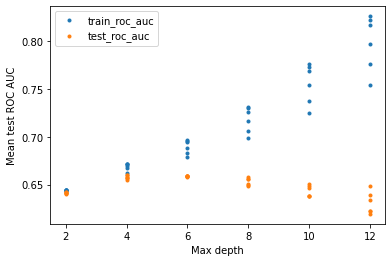

In [89]:
plt.figure()
plt.xlabel("Max depth")
plt.ylabel("Mean test ROC AUC")
plt.plot(gridcv['param_max_depth'],gridcv['mean_train_roc_auc'],'.', label = 'train_roc_auc')
plt.plot(gridcv['param_max_depth'],gridcv['mean_test_roc_auc'],'.' ,label = 'test_roc_auc')
plt.legend()
plt.show()

In [101]:
from sklearn.metrics import confusion_matrix
dtreebest = DecisionTreeClassifier(max_depth = 4, class_weight = {0:0.5,1:0.5})
dtreebest.fit(X_train_unscaled,y_train)
y_pred = dtreebest.predict(X_test_unscaled)
cm = confusion_matrix(y_test,y_pred)

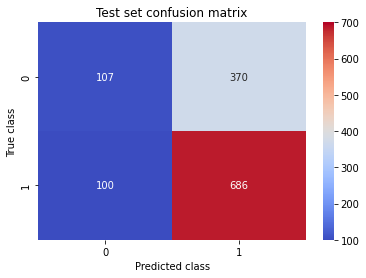

In [102]:
plt.figure()
sns.heatmap(cm,cmap="coolwarm",annot=True,fmt='g',vmax=700)
plt.title("Test set confusion matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()


True positives = 686
True negatives = 107
False positives = 370
False negatives = 100

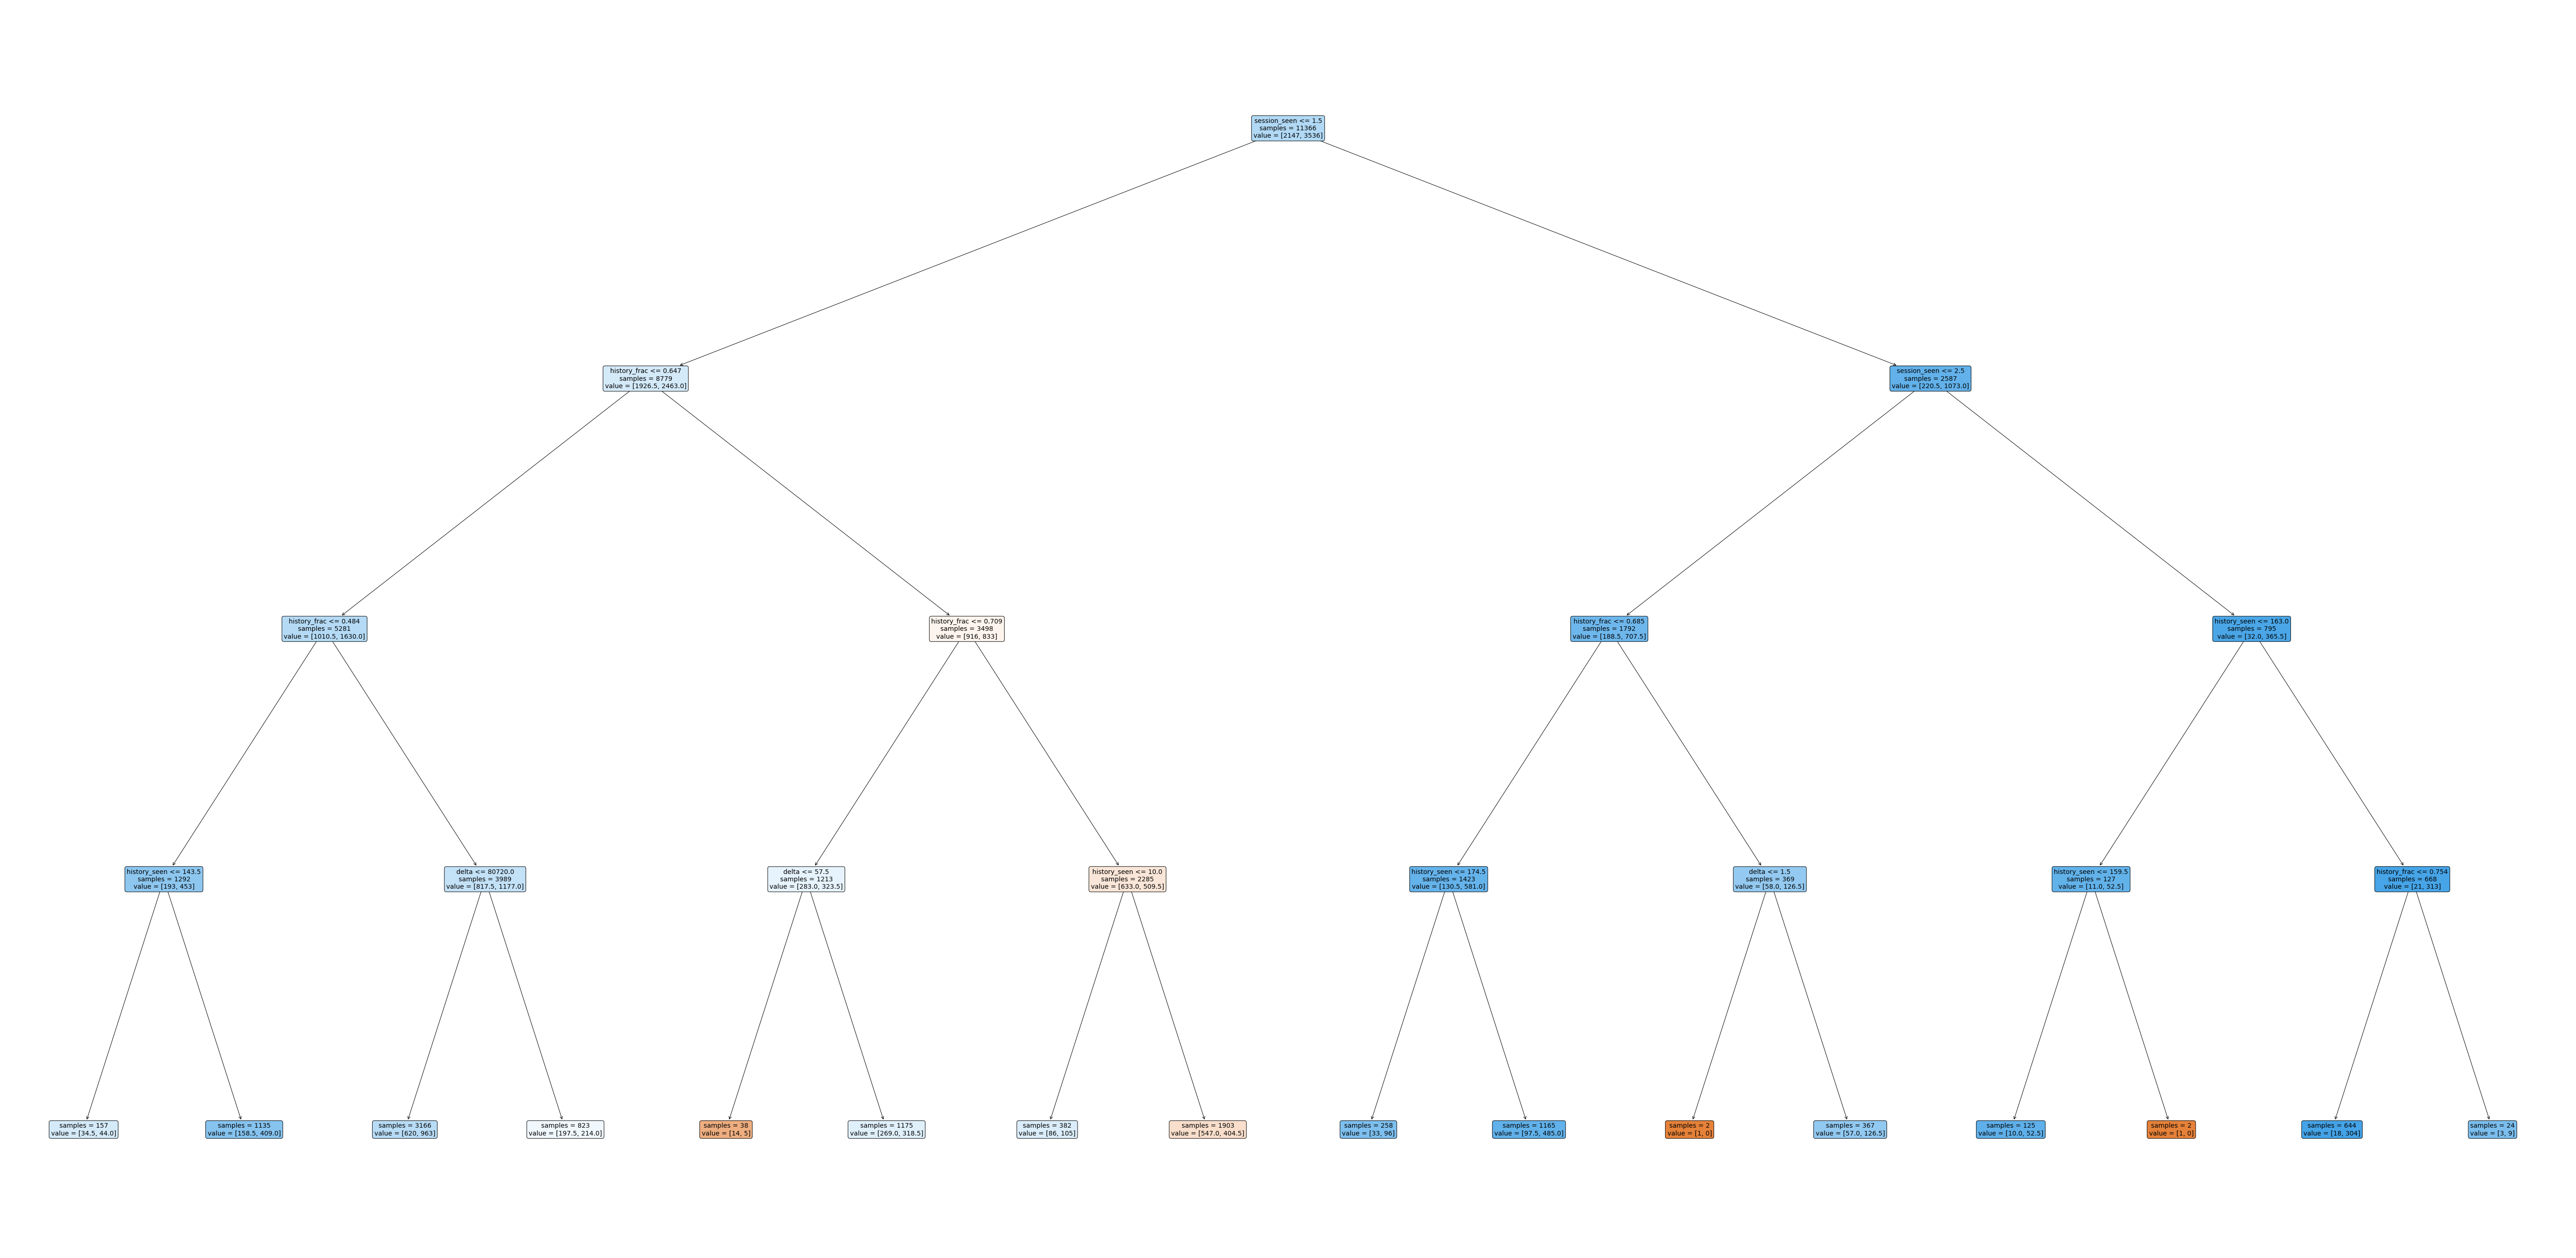

In [103]:
from sklearn.tree import plot_tree
plt.figure(figsize=(100,50))
plot_tree(dtreebest, 
          feature_names=X.columns, 
          rounded=True,
          impurity=False,
          filled=True,
          fontsize=14)
plt.show()

In [107]:
pd.Series(dict(zip(X_test_unscaled.columns,dtreebest.feature_importances_))).sort_values(ascending=False)

session_seen    0.636350
history_frac    0.273455
history_seen    0.053233
delta           0.036962
sf_length       0.000000
dtype: float64

In [96]:
# looking for false negatives 
X_test_unscaled[(y_test==1) & (y_pred==0)]

,delta,history_frac,history_seen,session_seen,sf_length
11958,104483,0.714286,56,1,5
6034,608,0.755119,3614,1,2
9469,82587,0.970588,34,1,9
1834,68,0.761946,3474,1,2
8308,88934,0.710692,159,1,3
...,...,...,...,...,...
6862,173677,0.870968,31,1,8
10690,1891,0.722222,144,1,4
2719,88688,0.634494,632,1,6
7383,643,0.716495,582,1,4


Checking XGboost performance

In [112]:
y_test.value_counts(normalize=True)

1    0.622328
0    0.377672
Name: p_forgot_bin, dtype: float64

In [110]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_unscaled)
X_mm_train = mm_scaler.transform(X_train_unscaled)
X_mm_test = mm_scaler.transform(X_test_unscaled)
XGB_model = XGBClassifier(num_feature = 2)
XGB_model.fit(X_mm_train, y_train)
print(f"XG Boost train set score: {XGB_model.score(X_mm_train, y_train)}")
print(f"XG Boost test set score: {XGB_model.score(X_mm_test, y_test)}")

XG Boost train set score: 0.6631180714411402
XG Boost test set score: 0.6381631037212985


In [121]:
from sklearn.ensemble import AdaBoostClassifier

AB_model = AdaBoostClassifier(n_estimators=200,learning_rate=.20)
AB_model.fit(X_mm_train, y_train)
print(f"Ada Boost train set score: {AB_model.score(X_mm_train, y_train)}")
print(f"Ada Boost test set score: {AB_model.score(X_mm_test, y_test)}")

Ada Boost train set score: 0.6531761393630124
Ada Boost test set score: 0.6421219319081551


In [123]:
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV

para_dict =dict()
para_dict['random_state'] = [1,12,123,1234]
para_dict['n_estimators'] = [5,10,50,100,150,200,300]
para_dict['learning_rate'] = [1,0.1,0.01]

AB_model = AdaBoostClassifier()

scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(AB_model, param_grid = para_dict,cv=4,scoring = scoring_metrics, verbose=15,refit=False,return_train_score=True)

gridsearch_obj.fit(X_train_unscaled,y_train)

Fitting 4 folds for each of 84 candidates, totalling 336 fits
[CV 1/4; 1/84] START learning_rate=1, n_estimators=5, random_state=1............
[CV 1/4; 1/84] END learning_rate=1, n_estimators=5, random_state=1; accuracy: (train=0.644, test=0.641) average_precision: (train=0.751, test=0.742) f1: (train=0.748, test=0.746) recall: (train=0.850, test=0.848) roc_auc: (train=0.663, test=0.652) total time=   0.1s
[CV 2/4; 1/84] START learning_rate=1, n_estimators=5, random_state=1............
[CV 2/4; 1/84] END learning_rate=1, n_estimators=5, random_state=1; accuracy: (train=0.640, test=0.643) average_precision: (train=0.760, test=0.754) f1: (train=0.736, test=0.740) recall: (train=0.808, test=0.818) roc_auc: (train=0.664, test=0.661) total time=   0.1s
[CV 3/4; 1/84] START learning_rate=1, n_estimators=5, random_state=1............
[CV 3/4; 1/84] END learning_rate=1, n_estimators=5, random_state=1; accuracy: (train=0.647, test=0.635) average_precision: (train=0.758, test=0.753) f1: (train=0

GridSearchCV(cv=4, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'n_estimators': [5, 10, 50, 100, 150, 200, 300],
                         'random_state': [1, 12, 123, 1234]},
             refit=False, return_train_score=True,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=15)

In [126]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
gridresults = np.around(gridcv[['param_random_state','param_n_estimators','param_learning_rate','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

gridresults.sort_values(by='mean_test_accuracy',ascending=False).head(4)

,param_random_state,param_n_estimators,param_learning_rate,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
4,1,10,1,0.08,0.02,0.65,0.76,0.66,0.75,0.87
5,12,10,1,0.08,0.02,0.65,0.76,0.66,0.75,0.87
6,123,10,1,0.08,0.02,0.65,0.76,0.66,0.75,0.87
7,1234,10,1,0.12,0.04,0.65,0.76,0.66,0.75,0.87


In [128]:
gridresults.sort_values(by='mean_test_average_precision',ascending=False).head(4)

,param_random_state,param_n_estimators,param_learning_rate,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
42,123,100,0.1,0.69,0.12,0.64,0.78,0.67,0.75,0.88
52,1,300,0.1,2.02,0.32,0.64,0.78,0.67,0.75,0.87
40,1,100,0.1,0.78,0.15,0.64,0.78,0.67,0.75,0.88
41,12,100,0.1,0.82,0.14,0.64,0.78,0.67,0.75,0.88


In [130]:
AB_best = AdaBoostClassifier(random_state=1,n_estimators=10,learning_rate=1)
AB_best.fit(X_mm_train,y_train)
y_pred = AB_best.predict(X_mm_test)

In [133]:
pd.Series(dict(zip(X_test_unscaled.columns,AB_best.feature_importances_)))

delta           0.2
history_frac    0.2
history_seen    0.2
session_seen    0.4
sf_length       0.0
dtype: float64

Surface length does not seem to matter for this student. session seen is important as a feature.

Adding part of speech, removing word length:

In [136]:
user1 = datadfq1.loc[datadfq1['user_id']=='u:bcH_']
user1['history_frac'] = user1['history_correct']/user1['history_seen']
user1 = user1[['delta','history_frac','p_recall','history_seen','session_seen','lexeme_id','timestamp']] # added session seen.
user1['p_forgot'] = 1 - user1['p_recall']
user1['p_forgot_bin'] = np.where(user1['p_forgot']>0,1,0).astype(int)
user1 = user1.drop(['p_forgot'],axis=1)

q1lexemes_sub = q1lexemes[['lexeme_id','learning_language','sf_length','pos']]
user1_1 = pd.merge(left = user1, right = q1lexemes_sub,left_on = 'lexeme_id',right_on = 'lexeme_id',how='left')
user1_1 = user1_1.drop(['p_recall','lexeme_id','timestamp','learning_language'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [147]:
user1_1['partofspeech'] = [user1_1['pos'].loc[i][0] for i in range(user1_1['pos'].shape[0])]

In [148]:
user1_1['partofspeech'].head()

0        n
1        n
2    vblex
3    vblex
4    vblex
Name: partofspeech, dtype: object

In [149]:
user1_1 = user1_1.drop(['pos'],axis=1)

In [150]:
user1_1.head()

,delta,history_frac,history_seen,session_seen,p_forgot_bin,sf_length,partofspeech
0,61015,0.738854,157,1,1,4,n
1,83951,0.607735,181,1,1,5,n
2,61191,0.638554,913,1,1,4,vblex
3,83951,0.623656,93,1,1,6,vblex
4,150495,0.648276,145,1,0,4,vblex


In [153]:
posdummies = pd.get_dummies(user1_1['partofspeech'],drop_first=True,prefix='POS')
user1_1 = pd.concat([user1_1,posdummies],axis=1)
user1_1 = user1_1.drop('partofspeech',axis=1)
user1_1.head()

,delta,history_frac,history_seen,session_seen,p_forgot_bin,sf_length,POS_adj,POS_adv,POS_cnjadv,POS_cnjcoo,...,POS_pr,POS_preadv,POS_predet,POS_prn,POS_rel,POS_vaux,POS_vbdo,POS_vbhaver,POS_vblex,POS_vbser
0,61015,0.738854,157,1,1,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,83951,0.607735,181,1,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,61191,0.638554,913,1,1,4,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,83951,0.623656,93,1,1,6,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,150495,0.648276,145,1,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [155]:
from sklearn.model_selection import train_test_split

X = user1_1.drop('p_forgot_bin',axis=1)
y = user1_1['p_forgot_bin']

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y)

In [156]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_unscaled)
X_mm_train = mm_scaler.transform(X_train_unscaled)
X_mm_test = mm_scaler.transform(X_test_unscaled)
XGB_model = XGBClassifier(num_feature = 2)
XGB_model.fit(X_mm_train, y_train)
print(f"XG Boost train set score: {XGB_model.score(X_mm_train, y_train)}")
print(f"XG Boost test set score: {XGB_model.score(X_mm_test, y_test)}")

XG Boost train set score: 0.6670814479638009
XG Boost test set score: 0.6474003694906307


In [157]:
from sklearn.ensemble import AdaBoostClassifier

AB_model = AdaBoostClassifier(n_estimators=200,learning_rate=.20)
AB_model.fit(X_mm_train, y_train)
print(f"Ada Boost train set score: {AB_model.score(X_mm_train, y_train)}")
print(f"Ada Boost test set score: {AB_model.score(X_mm_test, y_test)}")

Ada Boost train set score: 0.648868778280543
Ada Boost test set score: 0.6413301662707839


In [158]:
from sklearn.model_selection import cross_validate

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV

para_dict =dict()
para_dict['random_state'] = [1,12,123,1234]
para_dict['n_estimators'] = [5,10,50,100,150,200,300]
para_dict['learning_rate'] = [1,0.1,0.01]

AB_model = AdaBoostClassifier()

scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(AB_model, param_grid = para_dict,cv=4,scoring = scoring_metrics, verbose=15,refit=False,return_train_score=True)

gridsearch_obj.fit(X_train_unscaled,y_train)

Fitting 4 folds for each of 84 candidates, totalling 336 fits
[CV 1/4; 1/84] START learning_rate=1, n_estimators=5, random_state=1............
[CV 1/4; 1/84] END learning_rate=1, n_estimators=5, random_state=1; accuracy: (train=0.638, test=0.638) average_precision: (train=0.760, test=0.744) f1: (train=0.725, test=0.724) recall: (train=0.765, test=0.764) roc_auc: (train=0.668, test=0.654) total time=   0.1s
[CV 2/4; 1/84] START learning_rate=1, n_estimators=5, random_state=1............
[CV 2/4; 1/84] END learning_rate=1, n_estimators=5, random_state=1; accuracy: (train=0.643, test=0.632) average_precision: (train=0.750, test=0.748) f1: (train=0.736, test=0.727) recall: (train=0.802, test=0.788) roc_auc: (train=0.660, test=0.655) total time=   0.1s
[CV 3/4; 1/84] START learning_rate=1, n_estimators=5, random_state=1............
[CV 3/4; 1/84] END learning_rate=1, n_estimators=5, random_state=1; accuracy: (train=0.644, test=0.633) average_precision: (train=0.758, test=0.744) f1: (train=0

GridSearchCV(cv=4, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'n_estimators': [5, 10, 50, 100, 150, 200, 300],
                         'random_state': [1, 12, 123, 1234]},
             refit=False, return_train_score=True,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=15)

In [159]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
gridresults = np.around(gridcv[['param_random_state','param_n_estimators','param_learning_rate','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

gridresults.sort_values(by='mean_test_accuracy',ascending=False).head(4)

,param_random_state,param_n_estimators,param_learning_rate,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
42,123,100,0.1,0.78,0.15,0.64,0.77,0.67,0.75,0.87
48,1,200,0.1,2.36,0.51,0.64,0.78,0.67,0.75,0.86
24,1,300,1,2.35,0.39,0.64,0.77,0.66,0.74,0.84
25,12,300,1,3.77,0.59,0.64,0.77,0.66,0.74,0.84


In [160]:
gridresults.sort_values(by='mean_test_average_precision',ascending=False).head(4)

,param_random_state,param_n_estimators,param_learning_rate,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
46,123,150,0.1,1.17,0.21,0.64,0.78,0.67,0.75,0.87
52,1,300,0.1,2.30,0.39,0.64,0.78,0.67,0.75,0.86
45,12,150,0.1,1.37,0.20,0.64,0.78,0.67,0.75,0.87
44,1,150,0.1,1.73,0.28,0.64,0.78,0.67,0.75,0.87


Not better than with just surface length. 

Adding modifiers. 

In [216]:
[col for col in q1lexemes.columns if col.startswith('mod_')]

['mod_*gndr',
 'mod_*numb',
 'mod_*pers',
 'mod_@compound_past',
 'mod_@cond_perfect',
 'mod_@det:a_le',
 'mod_@det:de_le',
 'mod_@formal',
 'mod_@future',
 'mod_@future_perfect',
 'mod_@future_phrasal',
 'mod_@ger_past',
 'mod_@n:petit_ami',
 'mod_@neg:il_ne_y_a',
 'mod_@obj',
 'mod_@passive',
 'mod_@past',
 'mod_@past_cond',
 'mod_@past_inf',
 'mod_@past_perfect',
 'mod_@past_subjunctive',
 'mod_@pluperfect',
 'mod_@pos',
 'mod_@present_perfect',
 'mod_@prn:ce_dont',
 'mod_@prn:celui_ci',
 'mod_@prn:celui_la',
 'mod_@prn:celui_que',
 'mod_@prn:l_un',
 'mod_@prn:le_mien',
 'mod_@prn:le_tien',
 'mod_@prn:quelque_chose',
 'mod_@prn:quelque_un',
 'mod_@ref',
 'mod_@subjunctive_pluperfect',
 'mod_acr',
 'mod_adv',
 'mod_an',
 'mod_ant',
 'mod_cni',
 'mod_comp',
 'mod_def',
 'mod_dem',
 'mod_det',
 'mod_dim',
 'mod_enc',
 'mod_f',
 'mod_fti',
 'mod_ger',
 'mod_ifi',
 'mod_imp',
 'mod_ind',
 'mod_inf',
 'mod_itg',
 'mod_loc',
 'mod_m',
 'mod_mf',
 'mod_nn',
 'mod_nt',
 'mod_obj',
 'mod_ord'

In [255]:
user1 = datadfq1.loc[datadfq1['user_id']=='u:IY_']
user1['history_frac'] = user1['history_correct']/user1['history_seen']
user1 = user1[['delta','history_frac','p_recall','history_seen','session_seen','lexeme_id','timestamp']] # added session seen.
user1['p_forgot'] = 1 - user1['p_recall']
user1['p_forgot_bin'] = np.where(user1['p_forgot']>0,1,0).astype(int)
user1 = user1.drop(['p_forgot'],axis=1)

q1lexemes_sub = q1lexemes[['lexeme_id','learning_language','sf_length','pos']+[col for col in q1lexemes.columns if col.startswith('mod_')]]
user1_1 = pd.merge(left = user1, right = q1lexemes_sub,left_on = 'lexeme_id',right_on = 'lexeme_id',how='left')
user1_1 = user1_1.drop(['p_recall','lexeme_id','timestamp','learning_language'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [256]:
user1_1['partofspeech'] = [user1_1['pos'].loc[i][0] for i in range(user1_1['pos'].shape[0])]
posdummies = pd.get_dummies(user1_1['partofspeech'],drop_first=True,prefix='POS')
user1_1 = pd.concat([user1_1,posdummies],axis=1)
user1_1 = user1_1.drop(['partofspeech','pos'],axis=1)
user1_1.head()

,delta,history_frac,history_seen,session_seen,p_forgot_bin,sf_length,mod_*gndr,mod_*numb,mod_*pers,mod_@compound_past,...,POS_pr,POS_preadv,POS_predet,POS_prn,POS_rel,POS_vaux,POS_vbdo,POS_vbhaver,POS_vblex,POS_vbser
0,65851,0.279070,43,1,0,6,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,66092,0.225000,40,1,0,12,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,55877,0.657143,105,1,0,6,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,55353,0.681901,547,1,0,3,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,55353,0.261538,130,1,1,4,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [257]:
user1_1.shape

(5528, 110)

In [258]:
from sklearn.model_selection import train_test_split

X = user1_1.drop('p_forgot_bin',axis=1)
y = user1_1['p_forgot_bin']

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X,y,test_size=.1,stratify=y)

In [259]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_unscaled)
X_mm_train = mm_scaler.transform(X_train_unscaled)
X_mm_test = mm_scaler.transform(X_test_unscaled)
XGB_model = XGBClassifier(num_feature = 5,subsample = 0.5)
XGB_model.fit(X_mm_train, y_train)
print(f"XG Boost train set score: {XGB_model.score(X_mm_train, y_train)}")
print(f"XG Boost test set score: {XGB_model.score(X_mm_test, y_test)}")

XG Boost train set score: 0.6693467336683417
XG Boost test set score: 0.596745027124774


In [260]:
y_probaXBG = XGB_model.predict_proba(X_mm_test)[:,1]

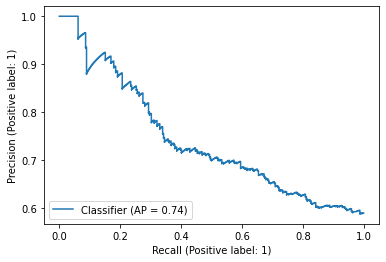

In [262]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test,y_probaXBG)

Some improvement. slight, but there. 

In [263]:
from sklearn.ensemble import AdaBoostClassifier

AB_model = AdaBoostClassifier(n_estimators=200,learning_rate=.20)
AB_model.fit(X_mm_train, y_train)
print(f"Ada Boost train set score: {AB_model.score(X_mm_train, y_train)}")
print(f"Ada Boost test set score: {AB_model.score(X_mm_test, y_test)}")

Ada Boost train set score: 0.6257286432160803
Ada Boost test set score: 0.6166365280289331


In [192]:
from sklearn.model_selection import cross_validate

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV

para_dict =dict()
#para_dict['random_state'] = [1,12]
#para_dict['n_estimators'] = [150]
para_dict['learning_rate'] = [1,0.1,0.01]

AB_model = AdaBoostClassifier(n_estimators=150)

scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(AB_model, param_grid = para_dict,cv=4,scoring = scoring_metrics, verbose=15,refit=False,return_train_score=True)

gridsearch_obj.fit(X_train_unscaled,y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4; 1/3] START learning_rate=1.............................................
[CV 1/4; 1/3] END learning_rate=1; accuracy: (train=0.665, test=0.649) average_precision: (train=0.803, test=0.766) f1: (train=0.764, test=0.752) recall: (train=0.869, test=0.854) roc_auc: (train=0.704, test=0.656) total time=   3.9s
[CV 2/4; 1/3] START learning_rate=1.............................................
[CV 2/4; 1/3] END learning_rate=1; accuracy: (train=0.662, test=0.634) average_precision: (train=0.798, test=0.773) f1: (train=0.760, test=0.741) recall: (train=0.862, test=0.843) roc_auc: (train=0.699, test=0.666) total time=   2.6s
[CV 3/4; 1/3] START learning_rate=1.............................................
[CV 3/4; 1/3] END learning_rate=1; accuracy: (train=0.657, test=0.651) average_precision: (train=0.799, test=0.776) f1: (train=0.759, test=0.754) recall: (train=0.867, test=0.859) roc_auc: (train=0.698, test=0.670) total time=   

GridSearchCV(cv=4, estimator=AdaBoostClassifier(n_estimators=150),
             param_grid={'learning_rate': [1, 0.1, 0.01]}, refit=False,
             return_train_score=True,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=15)

In [264]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
gridresults = np.around(gridcv[['param_learning_rate','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

gridresults.sort_values(by='mean_test_accuracy',ascending=False).head(4)

,param_learning_rate,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,1,2.51,0.40,0.64,0.77,0.67,0.75,0.85
1,0.1,2.71,0.44,0.64,0.78,0.67,0.75,0.87
2,0.01,2.25,0.36,0.62,0.74,0.65,0.77,1.00


In [265]:
gridresults.sort_values(by='mean_test_average_precision',ascending=False).head(4)

,param_learning_rate,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
1,0.1,2.71,0.44,0.64,0.78,0.67,0.75,0.87
0,1,2.51,0.40,0.64,0.77,0.67,0.75,0.85
2,0.01,2.25,0.36,0.62,0.74,0.65,0.77,1.00


In [266]:
AB_model = AdaBoostClassifier(n_estimators=150, learning_rate=1)

AB_model.fit(X_train_unscaled,y_train)
y_probaAB = AB_model.predict_proba(X_test_unscaled)[:,1]

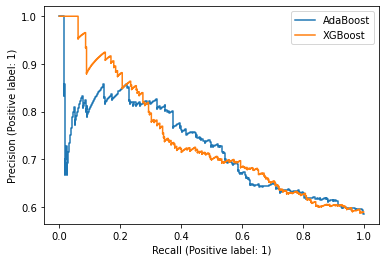

In [267]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay
plt.figure()
ax = plt.gca()
PrecisionRecallDisplay.from_predictions(y_test,y_probaAB,ax=ax,label="AdaBoost")
PrecisionRecallDisplay.from_predictions(y_test,y_probaXBG,ax=ax,label="XGBoost")
plt.legend()
plt.show()

In [268]:
accuracy_score(y_test,np.where(y_probaAB>=0.5,1,0)), accuracy_score(y_test,np.where(y_probaXBG>=0.5,1,0))

(0.596745027124774, 0.596745027124774)

add the character 2 and 3 grams.

In [270]:
pd.Series(dict(zip(X_test_unscaled.columns,AB_model.feature_importances_))).sort_values(ascending=False).head(10)

delta                0.373333
history_seen         0.226667
history_frac         0.200000
session_seen         0.033333
sf_length            0.026667
mod_comp             0.006667
POS_cnjcoo           0.006667
mod_@past_perfect    0.006667
POS_det              0.006667
POS_ij               0.006667
dtype: float64

In [243]:
user1 = datadfq1.loc[datadfq1['user_id']=='u:bcH_']
user1['history_frac'] = user1['history_correct']/user1['history_seen']
user1 = user1[['delta','history_frac','p_recall','history_seen','session_seen','lexeme_id','timestamp']] # added session seen.
user1['p_forgot'] = 1 - user1['p_recall']
user1['p_forgot_bin'] = np.where(user1['p_forgot']>0,1,0).astype(int)
user1 = user1.drop(['p_forgot'],axis=1)

q1lexemes_sub = q1lexemes#q1lexemes[['lexeme_id','learning_language','sf_length','pos']+[col for col in q1lexemes.columns if (q1lexemes[col].dtype!='object')]]
user1_1 = pd.merge(left = user1, right = q1lexemes_sub,left_on = 'lexeme_id',right_on = 'lexeme_id',how='left')
user1_1 = user1_1.drop(['p_recall','lexeme_id','timestamp','learning_language'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [244]:
user1_1['partofspeech'] = [user1_1['pos'].loc[i][0] for i in range(user1_1['pos'].shape[0])]
posdummies = pd.get_dummies(user1_1['partofspeech'],drop_first=True,prefix='POS')
user1_1 = pd.concat([user1_1,posdummies],axis=1)
user1_1 = user1_1.drop(['partofspeech','pos','index'],axis=1)
user1_1.head()

,delta,history_frac,history_seen,session_seen,p_forgot_bin,lexeme_string,surface_form,lemma_form,modstrings,sf_length,...,POS_pr,POS_preadv,POS_predet,POS_prn,POS_rel,POS_vaux,POS_vbdo,POS_vbhaver,POS_vblex,POS_vbser
0,61015,0.738854,157,1,1,milk/milk<n><sg>,milk,milk,[sg],4,...,0,0,0,0,0,0,0,0,0,0
1,83951,0.607735,181,1,1,music/music<n><sg>,music,music,[sg],5,...,0,0,0,0,0,0,0,0,0,0
2,61191,0.638554,913,1,1,have/have<vblex><inf>,have,have,[inf],4,...,0,0,0,0,0,0,0,0,1,0
3,83951,0.623656,93,1,1,listen/listen<vblex><pres>,listen,listen,[pres],6,...,0,0,0,0,0,0,0,0,1,0
4,150495,0.648276,145,1,0,love/love<vblex><pres>,love,love,[pres],4,...,0,0,0,0,0,0,0,0,1,0


In [245]:
user1_1 = user1_1.select_dtypes(exclude='object')

In [246]:
from sklearn.model_selection import train_test_split

X = user1_1.drop('p_forgot_bin',axis=1)
y = user1_1['p_forgot_bin']

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X,y,test_size=.1,stratify=y)

In [247]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train_unscaled)
X_mm_train = mm_scaler.transform(X_train_unscaled)
X_mm_test = mm_scaler.transform(X_test_unscaled)
XGB_model = XGBClassifier(num_feature = 5,subsample = 0.5)
XGB_model.fit(X_mm_train, y_train)
print(f"XG Boost train set score: {XGB_model.score(X_mm_train, y_train)}")
print(f"XG Boost test set score: {XGB_model.score(X_mm_test, y_test)}")

XG Boost train set score: 0.6732359669188809
XG Boost test set score: 0.6460807600950119


In [248]:
y_probaXGB = XGB_model.predict_proba(X_mm_test)[:,1]

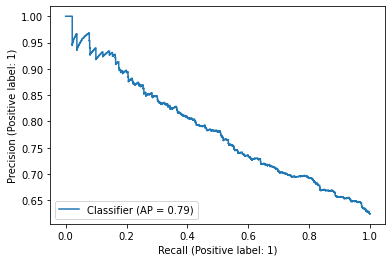

In [249]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test,y_probaXGB)

In [250]:
AB_model = AdaBoostClassifier(n_estimators=150, learning_rate=1)

AB_model.fit(X_train_unscaled,y_train)
y_probaAB = AB_model.predict_proba(X_test_unscaled)[:,1]

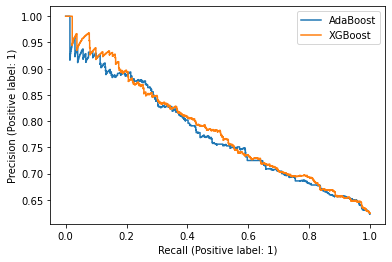

In [251]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay
plt.figure()
ax = plt.gca()
PrecisionRecallDisplay.from_predictions(y_test,y_probaAB,ax=ax,label="AdaBoost")
PrecisionRecallDisplay.from_predictions(y_test,y_probaXGB,ax=ax,label="XGBoost")
plt.legend()
plt.show()

In [254]:
pd.Series(dict(zip(X_test_unscaled.columns,AB_model.feature_importances_))).sort_values(ascending=False).head(10)

delta           0.120000
history_frac    0.066667
history_seen    0.053333
session_seen    0.033333
ea              0.013333
ns              0.013333
oo              0.013333
lan             0.006667
king            0.006667
in              0.006667
dtype: float64

Take a subset of 20,000, and use all features. expect around 0.6-0.65 accuracy. 

In [1]:
user1 = datadfq1.sample(frac=1).loc[:20000,:]
user1['history_frac'] = user1['history_correct']/user1['history_seen']
user1 = user1[['delta','history_frac','p_recall','history_seen','session_seen','lexeme_id','timestamp']] # added session seen.
user1['p_forgot'] = 1 - user1['p_recall']
user1['p_forgot_bin'] = np.where(user1['p_forgot']>0,1,0).astype(int)
user1 = user1.drop(['p_forgot'],axis=1)

q1lexemes_sub = q1lexemes#q1lexemes[['lexeme_id','learning_language','sf_length','pos']+[col for col in q1lexemes.columns if (q1lexemes[col].dtype!='object')]]
user1_1 = pd.merge(left = user1, right = q1lexemes_sub,left_on = 'lexeme_id',right_on = 'lexeme_id',how='left')
user1_1 = user1_1.drop(['p_recall','lexeme_id','timestamp','learning_language','index'],axis=1)

NameError: ignored

In [ ]:
user1_1['partofspeech'] = [user1_1['pos'].loc[i][0] for i in range(user1_1['pos'].shape[0])]
posdummies = pd.get_dummies(user1_1['partofspeech'],drop_first=True,prefix='POS')
user1_1 = pd.concat([user1_1,posdummies],axis=1)
user1_1 = user1_1.drop(['partofspeech','pos','index'],axis=1)
user1_1.head()

In [ ]:
user1_1 = user1_1.select_dtypes(exclude='object')

In [ ]:
from sklearn.model_selection import train_test_split

X = user1_1.drop('p_forgot_bin',axis=1)
y = user1_1['p_forgot_bin']

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X,y,test_size=.1,stratify=y)